In [1]:
using Statistics
using DelimitedFiles
using Dates
using Flux
using MLDataUtils
using Random
using LinearAlgebra
using StatsBase
using Flux: onehotbatch, onecold, crossentropy, DataLoader
using Statistics
using Plots
using CSV
using DataFrames
using Distributions

In [2]:
# Probability function
function PSPACS(n, nbar, Ploss)
    if n == 0
        return 0
    elseif n == 1
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / Inf)))) * (1 - Ploss)^nbar
    else
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / factorial(n - 2))))) * (1 - Ploss)^nbar
    end
end

function PSPATS(n, nbar, Ploss)
    if n == 0
        return 0
    else
        return ((nbar ^ (n - 1) / (1 + nbar) ^ (n + 1)) * binomial(n, 1)) * (1 - Ploss)^nbar
    end
end

function dataGen(source, nbar, NExperiment, Ploss)
    # Zeros  = round(Int, NExperiment * source(0, nbar))
    Ones   = round(Int, NExperiment * source(1, nbar, Ploss))
    Twos   = round(Int, NExperiment * source(2, nbar, Ploss))
    Threes = round(Int, NExperiment * source(3, nbar, Ploss))
    Fours  = round(Int, NExperiment * source(4, nbar, Ploss))
    Fives  = round(Int, NExperiment * source(5, nbar, Ploss))
    Sixes  = round(Int, NExperiment * source(6, nbar, Ploss))

    data = []
    photonCounts = [Ones, Twos, Threes, Fours, Fives, Sixes]
    for i in 1:6
        photons =  zeros(photonCounts[i]) .+ (i)
        data = vcat(data, photons)
    end

    shuffle!(data)

    return data
end

function getProbs(data)
    return [count(x -> x == i, data) / size(data, 1) for i in 1:6]
end

function preprocess(spacs, spats, split)
    spacs = hcat(spacs, zeros(size(spacs, 1)))
    trainSpacs, testSpacs = spacs[1:Int(round(size(spacs, 1)*split)), :], spacs[Int(round(size(spacs, 1)*split))+1:end, :]
    spats = hcat(spats, ones(size(spats, 1)))
    trainSpats, testSpats = spats[1:Int(round(size(spats, 1)*split)), :], spats[Int(round(size(spats, 1)*split))+1:end, :]
    trainData = vcat(trainSpacs, trainSpats)
    testData = vcat(testSpacs, testSpats)
    trainData = trainData[shuffle(1:size(trainData, 1)), :]
    testData = testData[shuffle(1:size(testData, 1)), :]
    trainX, trainY, testX, testY = trainData[:, 1:end-1], trainData[:, end], testData[:, 1:end-1], testData[:, end]
    return trainX, trainY, testX, testY
end

function generateData(Ploss, binSize, nsamples, NExperiment, nbar, probs = false)
    spacs = dataGen(PSPACS, nbar, NExperiment, Ploss)
    spats = dataGen(PSPATS, nbar, NExperiment, Ploss)
    spacsData, spatsData = [], []
    spacsProbs, spatsProbs = [], []
    for _ in 1:nsamples
        sampleSpacs = sample(spacs, binSize)
        sampleSpats = sample(spats, binSize)
        spacsData = vcat(spacsData, [sampleSpacs])
        spatsData = vcat(spatsData, [sampleSpats])
        spacsProb, spatsProb = getProbs(sampleSpacs), getProbs(sampleSpats)
        spacsProbs = vcat(spacsProbs, [spacsProb])
        spatsProbs = vcat(spatsProbs, [spatsProb])
    end
    spacsData = hcat(map(x -> Float32.(x), spacsData)...)'
    spatsData = hcat(map(x -> Float32.(x), spatsData)...)'

    spacsProbs = hcat(map(x -> Float32.(x), spacsProbs)...)'
    spatsProbs = hcat(map(x -> Float32.(x), spatsProbs)...)'

    if probs
        spacsProbs = (spacsProbs .- mean(spacsProbs, dims=2)) ./ std(spacsProbs, dims=2)
        spatsProbs = (spatsProbs .- mean(spatsProbs, dims=2)) ./ std(spatsProbs, dims=2)
        return spacsProbs, spatsProbs
    else
        spacsData = spacsData ./ 6
        spatsData = spatsData ./6
        return spacsData, spatsData
    end
end


generateData (generic function with 2 methods)

In [48]:
Ploss = 0.5
binSize = 40
numsamples = 1000
NExperiment = 1e8 + 4
nbar = 0.5

spacs, spats = generateData(Ploss, binSize, numsamples, NExperiment, nbar)
trainX, trainY, testX, testY = preprocess(spacs, spats, 0.75)

([0.6666666865348816 0.5 … 0.6666666865348816 0.3333333432674408; 0.3333333432674408 0.1666666716337204 … 0.1666666716337204 0.1666666716337204; … ; 0.1666666716337204 0.1666666716337204 … 0.1666666716337204 0.6666666865348816; 0.1666666716337204 0.1666666716337204 … 0.5 0.5], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.6666666865348816 0.3333333432674408 … 0.3333333432674408 0.5; 0.1666666716337204 0.5 … 0.1666666716337204 0.3333333432674408; … ; 0.5 0.3333333432674408 … 0.1666666716337204 1.0; 0.5 0.1666666716337204 … 0.3333333432674408 0.6666666865348816], [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0  …  1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0])

In [78]:
# Define the encoder
function getEncoder(input_nodes, hidden1, latent)
    encoder = Chain(
        Dense(input_nodes, hidden1, relu),
        Dense(hidden1, latent, σ)
    )
    return encoder
end

# Define the decoder
function getDecoder(input_nodes, hidden1, latent)
    decoder = Chain(
        Dense(latent, hidden1, σ),
        Dense(hidden1, input_nodes, relu)
    )
    return decoder
end

# Combine into an autoencoder
function getAutoEncoder(input_nodes, hidden, latent)
    encoder, decoder = getEncoder(input_nodes, hidden, latent), getDecoder(input_nodes, hidden, latent)
    autoencoder = Chain(encoder, decoder)
    return autoencoder, encoder, decoder
end

function getClassifier(latent, h1, out)
    classifier = Chain(
        Dense(latent, h1, relu),
        Dense(h1, out, σ)
    )
    return classifier
end


getClassifier (generic function with 1 method)

In [79]:
struct Individual
    W1::Matrix{Float32}
    b1::Vector{Float32}
    W2::Matrix{Float32}
    b2::Vector{Float32}
    W3::Matrix{Float32}
    b3::Vector{Float32}
    W4::Matrix{Float32}
    b4::Vector{Float32}
    W1σ::Matrix{Float32}
    b1σ::Vector{Float32}
    W2σ::Matrix{Float32}
    b2σ::Vector{Float32}
    W3σ::Matrix{Float32}
    b3σ::Vector{Float32}
    W4σ::Matrix{Float32}
    b4σ::Vector{Float32}
end


# parameters = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, W1σ, b1σ, W2σ, b2σ, W3σ, b3σ, W4σ, b4σ, W5σ, b5σ, W6σ, b6σ]
function Individual(input_nodes, hidden1, latent)
    autoencoder, encoder, decoder = getAutoEncoder(input_nodes, hidden1, latent)
    params = collect(Flux.params(autoencoder))
    indiv = []
    for p in params
        push!(indiv, p)
    end
    for p in params
        push!(indiv, randn(size(p)...))
    end
    return Individual(indiv...)
end

    

Individual

In [89]:
function getNN(I::Individual)
    # println(size(I.b1))
    encoder = Chain(Dense(I.W1, I.b1, relu), Dense(I.W2, I.b2), softmax)
    decoder = Chain(Dense(I.W3, I.b3), Dense(I.W4, I.b4, relu))
    return Chain(encoder, decoder)
end

function getAllparams(I::Individual)
    return hcat((getNNparams(I)), (getMutationRates(I)))
end

function getNNparams(I::Individual)
    return [I.W1, I.b1, I.W2, I.b2, I.W3, I.b3, I.W4, I.b4]
end

function getMutationRates(I::Individual)
    return [I.W1σ, I.b1σ, I.W2σ, I.b2σ, I.W3σ, I.b3σ, I.W4σ, I.b4σ]
end

function modify(σi)
    ƞ = 1/sqrt(2*size(σi, 1))
    ƞi = 1/sqrt(2*sqrt(size(σi, 1)))
    for i in 1:size(σi, 1)
        for j in 1:size(σi, 2)
            σi[i, j] = min(0.9, max(0.00009, σi[i, j] * exp(ƞ * rand(Normal(0, 1)) + ƞi * rand(Normal(0, 1)))))
        end
    end
    return σi
    
end
function get_normal(σ)
    matrix = ones(size(σ))
    for i in 1:size(σ, 1)
        for j in 1:size(σ, 2)
            matrix[i, j] = rand(Normal(0, σ[i, j]))
        end
    end
    return matrix
end
function mutate(i::Individual)
    W1, b1, W2, b2, W3, b3, W4, b4, W1σ, b1σ, W2σ, b2σ, W3σ, b3σ, W4σ, b4σ = getAllparams(i)
    W1σ, b1σ, W2σ, b2σ, W3σ, b3σ, W4σ, b4σ = modify.([W1σ, b1σ, W2σ, b2σ, W3σ, b3σ, W4σ, b4σ])

    mW1 = W1 .+ get_normal(W1σ)
    mb1 = b1 .+ get_normal(b1σ)
    mW2 = W2 .+ get_normal(W2σ)
    mb2 = b2 .+ get_normal(b2σ)
    mW3 = W3 .+ get_normal(W3σ)
    mb3 = b3 .+ get_normal(b3σ)
    mW4 = W4 .+ get_normal(W4σ)
    mb4 = b4 .+ get_normal(b4σ)
    
    return Individual(mW1, mb1, mW2, mb2, mW3, mb3, mW4, mb4, W1σ, b1σ, W2σ, b2σ, W3σ, b3σ, W4σ, b4σ)
end

function fitness(i::Individual, x)
    model = getNN(i)
    xhat = []
    for idx in 1:size(x, 1)
        push!(xhat, model(x[idx, :]))
    end
    xhat = hcat(map(x -> Float32.(x), xhat)...)'
    return Flux.mse(xhat, x)
end

function crossover(i1::Individual, i2::Individual, x)
    # println("cross")
    i1W1, i1b1, i1W2, i1b2, i1W3, i1b3, i1W4, i1b4 = getNNparams(i1)
    i2W1, i2b1, i2W2, i2b2, i2W3, i2b3, i2W4, i2b4 = getNNparams(i2)
    if fitness(i1, x) > fitness(i2, x)
        σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8 = getMutationRates(i1)
    else
        σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8 = getMutationRates(i2)
    end
    #σ1, σ2, σ3, σ4 = rand((i1.σ1, i2.σ1)), rand((i1.σ2, i2.σ2)), rand((i1.σ3, i2.σ3)), rand((i1.σ4, i2.σ4))
    child = Individual((i1W1 .+ i2W1) ./ 2, (i1b1 .+ i2b1) ./ 2, (i1W2 .+ i2W2) ./ 2, (i1b2 .+ i2b2) ./ 2, (i1W3 .+ i2W3) ./ 2, (i1b3 .+ i2b3) ./ 2, (i1W4 .+ i2W4) ./ 2, (i1b4 .+ i2b4) ./ 2, σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8)
    return child
end

function crossover_1ptx(i1::Individual, i2::Individual, x)
    # println("1ptx")
    i1W1, i1b1, i1W2, i1b2, i1W3, i1b3, i1W4, i1b4 = getNNparams(i1)
    i2W1, i2b1, i2W2, i2b2, i2W3, i2b3, i2W4, i2b4 = getNNparams(i2)
    if fitness(i1, x) > fitness(i2, x)
        σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8 = getMutationRates(i1)
    else
        σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8 = getMutationRates(i2)
    end
    # println("before $(size(i1b1)), $(size(i2b1))")
    w1 = hcat(i1W1[:, 1:Integer(size(i1W1, 2)/2)], i2W1[:, 1+Integer(size(i2W1, 2)/2):end])
    b1 = vcat(i1b1[1:Integer(size(i1b1, 1)/2)], i2b1[1+Integer(size(i2b1, 1)/2):end])
    w2 = hcat(i1W2[:, 1:Integer(size(i1W2, 2)/2)], i2W2[:, 1+Integer(size(i2W2, 2)/2):end])
    b2 = vcat(i1b2[1:Integer(size(i1b2, 1)/2)], i2b2[1+Integer(size(i2b2, 1)/2):end])
    w3 = hcat(i1W3[:, 1:Integer(size(i1W3, 2)/2)], i2W3[:, 1+Integer(size(i2W3, 2)/2):end])
    b3 = vcat(i1b3[1:Integer(size(i1b3, 1)/2)], i2b3[1+Integer(size(i2b3, 1)/2):end])
    w4 = hcat(i1W4[:, 1:Integer(size(i1W4, 2)/2)], i2W4[:, 1+Integer(size(i2W4, 2)/2):end])
    b4 = vcat(i1b4[1:Integer(size(i1b4, 1)/2)], i2b4[1+Integer(size(i2b4, 1)/2):end])
    # println(size(b1))
    child = Individual(w1, b1, w2, b2, w3, b3, w4, b4, σ1, σ2, σ3, σ4, σ5, σ6, σ7, σ8)
    return child
end

function generate_child(population, x)
    i1, i2 = rand(population), rand(population)
    if true
        return crossover_1ptx(mutate(i1), mutate(i2), x)
    end
    #     return crossover(mutate(i1), mutate(i2), x)
    # end
end

function get_current_best(population, x)
    final_fitness = [fitness(population[1], x), fitness(population[2], x)]
    winner = population[argmax(final_fitness)]
    return getNN(winner)
end

function getMR(mr, σ)
    for i in 1:size(mr, 1)
        for j in 1:size(mr, 2)
            mr[i, j] *= rand(Normal(0, σ))
        end
    end
    return mr
end

function createPopulation(μ)
    population = []
    for i in 1:μ
        push!(population, Individual(input_nodes, hidden1, latent))
    end
    return population
end

createPopulation (generic function with 1 method)

In [97]:
m = getAutoEncoder(60, 32, 6)

(Chain(Chain(Dense(60 => 32, relu), Dense(32 => 6, σ)), Chain(Dense(6 => 32, σ), Dense(32 => 60, relu))), Chain(Dense(60 => 32, relu), Dense(32 => 6, σ)), Chain(Dense(6 => 32, σ), Dense(32 => 60, relu)))

In [101]:
numParams = 0
for p in Flux.params(m)
    println(size(p))
end

(32, 60)
(32,)
(6, 32)
(6,)
(32, 6)
(32,)
(60, 32)
(60,)


In [105]:
log(((32*60) + 32 + (6*32) + 6 + (32*6) + 32 + (60 * 32) + 60) * 100)

12.984020427782584

In [96]:
function evolve(numGenerations, μ, λ, x)

    reconLosses = [] 
    latents = []
    population = createPopulation(μ)
    for generation in 1:numGenerations
        # println(size(population[1].b1))
        if generation % 100 == 0
            @info "Generation $generation"
        end
        popF = [fitness(i, x) for i in population]
        popC = deepcopy(population)
        p1 = popC[argmin(popF)]
        deleteat!(popC, argmin(popF))
        deleteat!(popF, argmin(popF))
        p2 = popC[argmin(popF)]
        offsprings = [generate_child(population, x) for _ in 1:λ]
        # println(offsprings[1].b1)
        fitnesses = [fitness(o, x) for o in offsprings]
        c1 = offsprings[argmin(fitnesses)]
        deleteat!(offsprings, argmin(fitnesses))
        deleteat!(fitnesses, argmin(fitnesses))
        c2 = offsprings[argmin(fitnesses)]
        population = [c1, c2, p1, p2]
        push!(reconLosses, fitness(c1, x))
        push!(latents, getNN(c1)[1])
        # if generation > 100
        #     if issorted(reconLosses[end-9:end])
        #         population = [c1, Individual(input_nodes, hidden1, latent), p1, p2]
        #     end
        # end
    end

    return reconLosses, latents
end

numGenerations = 500
μ, λ, x = 4, 20, vcat(trainX, testX)
input_nodes, hidden1, latent = 40, 32, 6
reconLosses, latents = evolve(numGenerations, μ, λ, x)

┌ Info: Generation 100
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/evoAE.ipynb:9
┌ Info: Generation 200
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/evoAE.ipynb:9


┌ Info: Generation 300
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/evoAE.ipynb:9
┌ Info: Generation 400
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/evoAE.ipynb:9


┌ Info: Generation 500
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/evoAE.ipynb:9


(Any[0.2198120777421309, 0.4109680008555455, 0.26203540823198107, 0.3319577226560124, 0.19412185488539718, 0.31694569320968835, 0.41989000573329976, 0.43899755524964373, 0.3863914700902041, 0.28599658060311156  …  0.48224721605096726, 0.27701391707641904, 0.26673398180661545, 0.23092728801470608, 0.2515940053561225, 0.42928968332368084, 0.26822738820106695, 0.58707508727288, 0.3789240494529747, 0.3510344204886681], Any[Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax), Chain(Dense(40 => 32, relu), Dense(32 => 6), softmax)  …  Chain(Dense(40 => 32, re

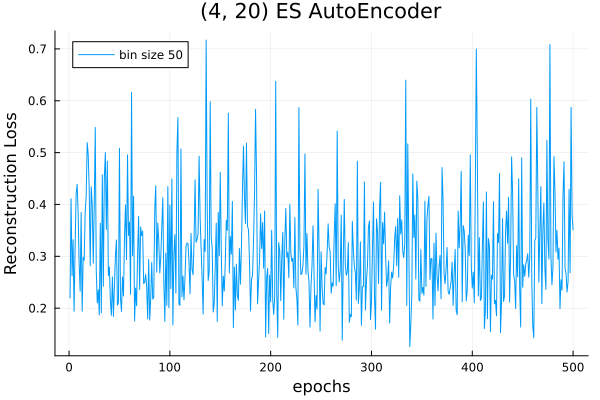

In [106]:
plot(1:size(reconLosses, 1), reconLosses, title = "(4, 20) ES AutoEncoder", xlabel="epochs", ylabel="Reconstruction Loss", label="bin size 50", )

In [95]:
latents

0.26501936165898554

In [94]:
data = vcat(trainX, testX)
l = []

for idx in 1:size(data, 1)
    push!(l, latents[end](data[idx, :]))
end

MethodError: MethodError: objects of type Float64 are not callable
Maybe you forgot to use an operator such as *, ^, %, / etc. ?

In [76]:
l

2000-element Vector{Any}:
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 ⋮
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [ ]:
classifier = getClassifier(encoder)
    epochs = classifierEpochs
    opt = ADAM(lr)
    loss(x, y) = Flux.mse(classifier(x), y)

    classifierTestLosses, classifierTestAccuracies = [], []
    for epoch in 1:epochs
        for (x, y) in train_data
            grads = Flux.gradient(Flux.params(classifier)) do
                loss(x, y)
            end
            Flux.Optimise.update!(opt, Flux.params(classifier), grads)
        end

        testloss = loss(testX', testYCold')
        testaccuracy = accuracy(testX',testYCold', classifier)

In [77]:
issorted([1 2 3 4 5])

true